In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask

import glob
import os
import sys

from scipy import spatial

%matplotlib inline

states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

df=gpd.read_file('/glade/u/home/currierw/work/shape/crb/b9522000.shp')
df

,AREA,GAGE_NA_ID,STAID,SITEID,NAME,BASIN,MI2,MI2USA,geometry
0,6.197680e+11,9522000,09522000,9522000,"Colorado R at NIB, ab Morelos Dam, nr Andrade,CA",Colo,239292,238186,"POLYGON ((-108.19123 35.12274, -108.19174 35.1..."


In [2]:
def getFlist(dirName,baseOut,timeStarList):
    for i in range(0,len(timeStarList)):
        fileListTmp=sorted(glob.glob(dirName+'/'+baseOut+timeStarList[i]))
        if i > 0:
            fileList.extend(fileListTmp)
        else:
            fileList=fileListTmp        
    return fileList

In [3]:
base       = '/glade/scratch/currierw/icar/crb/eraiLongNeg3mpNew/'
baseName   = ''

# Information related to the directory names in staggered icar runs
startDates = ['2000-09',    '2001-03',    '2001-09',   '2002-03',   '2002-09',   '2003-03',   '2003-09',   '2004-03']
endDates   = ['2001_04',    '2001_10',    '2002_04',   '2002_10',   '2003_04',   '2003_10',   '2004_04',   '2004_10']


fileStart = ['2000_10_01','2001_04_01','2001_10_01','2002_04_01','2002_10_01','2003_04_01','2003_10_01','2004_04_01']
fileEnd   = ['2001_03_31','2001_09_30','2002_03_31','2002_09_30','2003_03_31','2003_09_30','2004_03_31','2004_09_30']

    
dirName=base+baseName+startDates[0]+'_'+endDates[0]
fList=getFlist(dirName,'icar_out',['2000_10*','2000_11*','2000_12*'])
ds=xr.open_mfdataset(fList,combine='by_coords',parallel=True)
ds['lon']=(((ds['lon'] + 180) % 360) - 180)

In [4]:
# Bottom left starting
gridSpaceLon=ds['lon'][0,0]-ds['lon'][0,1] # difference in longitude
gridSpaceLat=ds['lat'][0,0]-ds['lat'][1,0] # difference in latitude

minDistance=np.abs([gridSpaceLon,gridSpaceLat]) # grid spacing
gridSpace=np.min(minDistance)
a2=(ds['lon'][0,0]-ds['lon'][0,-1]) * (ds['lon'][0,0]-ds['lon'][0,-1])
b2=(ds['lat'][-1,0]-ds['lat'][0,0]) * (ds['lat'][-1,0]-ds['lat'][0,0]) 
maxDistanceSearch=np.sqrt(a2+b2) - 3
phi=np.pi/4
xlin = maxDistanceSearch*np.cos(phi)+ds['lon'][0,0] # X (easting) coordinate at end of line direction phi
ylin = maxDistanceSearch*np.sin(phi)+ds['lat'][0,0] # Y (northing) coordinate at end of line direction phi

# xVec=np.arange(ds['lon'][0,0].values,xlin.values,gridSpace)
# yVec=np.arange(ds['lat'][0,0].values,ylin.values,gridSpace)

xVec=np.arange(ds['lon'][0,0].values,xlin.values,gridSpace)
yVec=np.arange(ds['lat'][0,0].values,ylin.values,gridSpace)

numPoints=np.max([len(xVec),len(yVec)])
numPoints

xVec2=np.linspace(ds['lon'][0,0].values,xlin.values,numPoints)
yVec2=np.linspace(ds['lat'][0,0].values,ylin.values,numPoints)


In [5]:
dsICAR=ds['z'][0,0,:,:]
pixel_center_points = np.stack((dsICAR.lat.values.flatten(), dsICAR.lon.values.flatten()), axis=-1)
tree = spatial.KDTree(pixel_center_points)

pixel_coords_list = [None] * len(xVec2)
lonArray      = np.ndarray(shape=len(xVec2),dtype=float,order='F')

for i in range(0,len(xVec2)):
    searchCoords = (yVec2[i],xVec2[i])
    distance, index = tree.query(searchCoords)
    pixel_coords = np.unravel_index(index, dsICAR.shape)
    pixel_coords_list[i]=[pixel_coords[0],pixel_coords[1]]
    lonArray[i]=dsICAR['lon'][pixel_coords].values
    

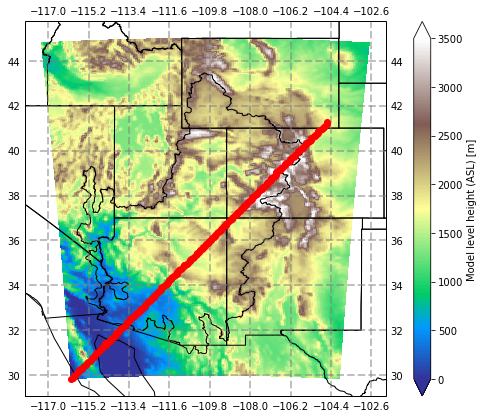

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

x = [i[0] for i in pixel_coords_list]
y = [i[1] for i in pixel_coords_list]
ax = plt.axes((0,0,1.3,1.3),projection=ccrs.PlateCarree())

ds['z'][0,0,:,:].plot(x='lon',y='lat',cmap='terrain',vmin=0,vmax=3500)
for i in range(0,len(pixel_coords_list)):
    plt.plot(ds['lon'][x[i],y[i]],ds['lat'][x[i],y[i]],'ro',linewidth=3)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.set_title('')
ax.add_geometries(states_gdf.geometry, crs = ccrs.PlateCarree(),facecolor='none', edgecolor='black')
ax.add_geometries(df.geometry, crs = ccrs.PlateCarree(),facecolor='none', edgecolor='black',linewidth =1)

In [ ]:
import matplotlib.image as mgimg
from matplotlib import animation

# #create empty list for images 
# myimages = []

time,lev,lat,lon=ds['qv'].shape
lonMat=np.tile(lonArray,(lev,1))

times=pd.date_range('2000-10-15','2000-12-31',freq='3H')

for tt in range(0,len(times)):

    if tt == 0:
        zArray=np.ndarray(shape=(lev,len(xVec2)), dtype=float, order='F')
        for i in range(0,len(xVec2)):
            zArray[:,i]=ds['z'][0,:,pixel_coords_list[i][0],pixel_coords_list[i][1]].values

    fig = plt.figure(figsize=(20, 20))
    heights = [1, 1, 1, 1, 1]
    widths = [1, 0.025]
    nrows = 5
    ncols = 2
    spec = fig.add_gridspec(ncols=ncols, nrows=nrows,
                            width_ratios=widths,
                            height_ratios=heights,
                            wspace=0.01, hspace=0.2)

    ax_maps = []
    for row in range(nrows):
        ax_maps.append(fig.add_subplot(spec[row, 0]))
    ax_cbar0 = fig.add_subplot(spec[0, 1])
    ax_cbar1 = fig.add_subplot(spec[1, 1])
    ax_cbar2 = fig.add_subplot(spec[2, 1])
    ax_cbar3 = fig.add_subplot(spec[3, 1])
    ax_cbar4 = fig.add_subplot(spec[4, 1])

    timestring = times[tt].strftime('%Y.%m.%d-%H')
    timestring
    
    # Water Vapor Mixing Ratio
    ax = ax_maps[0]   
    qvArray=np.ndarray(shape=(lev,len(xVec2)), dtype=float, order='F')
    dsSel=ds['qv'].sel(time=times[tt].strftime('%Y-%m-%d %H%M%S'))
    for i in range(0,len(xVec2)):
        qvArray[:,i]=dsSel[0,:,pixel_coords_list[i][0],pixel_coords_list[i][1]].values
    im = ax.pcolormesh(lonMat, zArray, qvArray,
                           cmap=plt.get_cmap('viridis'),
                      linewidth=0,
                      rasterized=True,
                      vmin=0,vmax=0.012)
    ax.set_ylabel('Height (m)')
    plt.colorbar(im, cax=ax_cbar0, extend='both')
    ax.set_title(timestring+' qv= Water Wapor Mixing Ratio')

    # Cloud Liquid Water Content
    ax = ax_maps[1]
    # (time, lev, lat_y, lon_x)
    dsSel=ds['qc'].sel(time=times[tt].strftime('%Y-%m-%d %H%M%S'))
    qcArray=np.ndarray(shape=(lev,len(xVec2)), dtype=float, order='F')
    for i in range(0,len(xVec2)):
        qcArray[:,i]=dsSel[0,:,pixel_coords_list[i][0],pixel_coords_list[i][1]].values
    im = ax.pcolormesh(lonMat, zArray, qcArray,
                           cmap=plt.get_cmap('viridis'),
                      linewidth=0,
                      rasterized=True,
                      vmin=0,vmax=0.0005)
    ax.set_ylabel('Height (m)')
    plt.colorbar(im, cax=ax_cbar1, extend='both')
    ax.set_title(timestring+' qc = Cloud liquid water content')

    # Cloud Ice Content
    ax = ax_maps[2]
    dsSel=ds['qi'].sel(time=times[tt].strftime('%Y-%m-%d %H%M%S'))
    qiArray=np.ndarray(shape=(lev,len(xVec2)), dtype=float, order='F')
    for i in range(0,len(xVec2)):
        qiArray[:,i]=dsSel[0,:,pixel_coords_list[i][0],pixel_coords_list[i][1]].values
    im = ax.pcolormesh(lonMat, zArray, qiArray,
                           cmap=plt.get_cmap('viridis'),
                      linewidth=0,
                      rasterized=True,
                      vmin=0,vmax=0.0005)
    ax.set_ylabel('Height (m)')
    plt.colorbar(im, cax=ax_cbar2, extend='both')
    ax.set_title(timestring+' qi = Cloud ice content')

    # Snow Content
    ax = ax_maps[3]
    dsSel=ds['qs'].sel(time=times[tt].strftime('%Y-%m-%d %H%M%S'))
    qsArray=np.ndarray(shape=(lev,len(xVec2)), dtype=float, order='F')
    for i in range(0,len(xVec2)):
        qsArray[:,i]=dsSel[0,:,pixel_coords_list[i][0],pixel_coords_list[i][1]].values    
    im = ax.pcolormesh(lonMat, zArray, qsArray,
                           cmap=plt.get_cmap('viridis'),
                      linewidth=0,
                      rasterized=True,
                      vmin=0,vmax=0.0005)
    ax.set_ylabel('Height (m)')
    plt.colorbar(im, cax=ax_cbar3, extend='both')
    ax.set_title(timestring+' qs= Snow ice content')

    # Potential Temperature
    ax = ax_maps[4]
    thArray=np.ndarray(shape=(lev,len(xVec2)), dtype=float, order='F')
    dsSel=ds['th'].sel(time=times[tt].strftime('%Y-%m-%d %H%M%S'))
    for i in range(0,len(xVec2)):
        thArray[:,i]=dsSel[0,:,pixel_coords_list[i][0],pixel_coords_list[i][1]].values  
    im = ax.pcolormesh(lonMat, zArray, thArray,
                           cmap=plt.get_cmap('magma'),
                      linewidth=0,
                      rasterized=True,
                      vmin=300,vmax=325)
    ax.set_ylabel('Height (m)')
    plt.colorbar(im, cax=ax_cbar4, extend='both')
    ax.set_title(timestring+' th = Potential Temperature')

    if tt==0:
        os.system('mkdir -p crossSection')
    
    fig.savefig('crossSection/delete'+str(tt).zfill(4)+'.png', dpi=300, bbox_inches='tight')
    plt.close(fig=fig)

# Make a video of the output .png's
# os.system('module load ffmpeg')
# os.system('ffmpeg -r 15 -pattern_type glob -i '*.png' -vcodec libx264 -vf scale=1280:-2,format=yuv420p movie.mp4')